<a href="https://colab.research.google.com/github/imadrian02/seg/blob/main/3Dkan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
# !kaggle datasets download -d awsaf49/brats20-dataset-training-validation
# !unzip "brats20-dataset-training-validation.zip"

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
User cancelled operation
Archive:  brats20-dataset-training-validation.zip
replace BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
replace BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#!pip install albumentations==0.4.6 pydicom nilearn numpy==1.26.4 scipy==1.13.1

In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip
from albumentations.pytorch import ToTensorV2

import warnings
warnings.simplefilter("ignore")

In [ ]:
import os
import shutil

# Names of your existing folders
src_train = '/content/BraTS2020_TrainingData'
src_val   = '/content/BraTS2020_ValidationData'

# New directory you want to create
dst_root = 'brats20-dataset-training-validation'

# 1. Create the destination directory if needed
os.makedirs(dst_root, exist_ok=True)

# 2. Move each folder into the new directory
for src in (src_train, src_val):
    src_path = os.path.abspath(src)
    dst_path = os.path.join(dst_root, os.path.basename(src))
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)
        print(f'Moved "{src_path}" → "{dst_path}"')
    else:
        print(f'Warning: source folder "{src_path}" does not exist')

Moved "/content/BraTS2020_TrainingData" → "brats20-dataset-training-validation/BraTS2020_TrainingData"
Moved "/content/BraTS2020_ValidationData" → "brats20-dataset-training-validation/BraTS2020_ValidationData"


In [ ]:
sample_filename = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_filename_mask = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [ ]:
sample_filename2 = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0

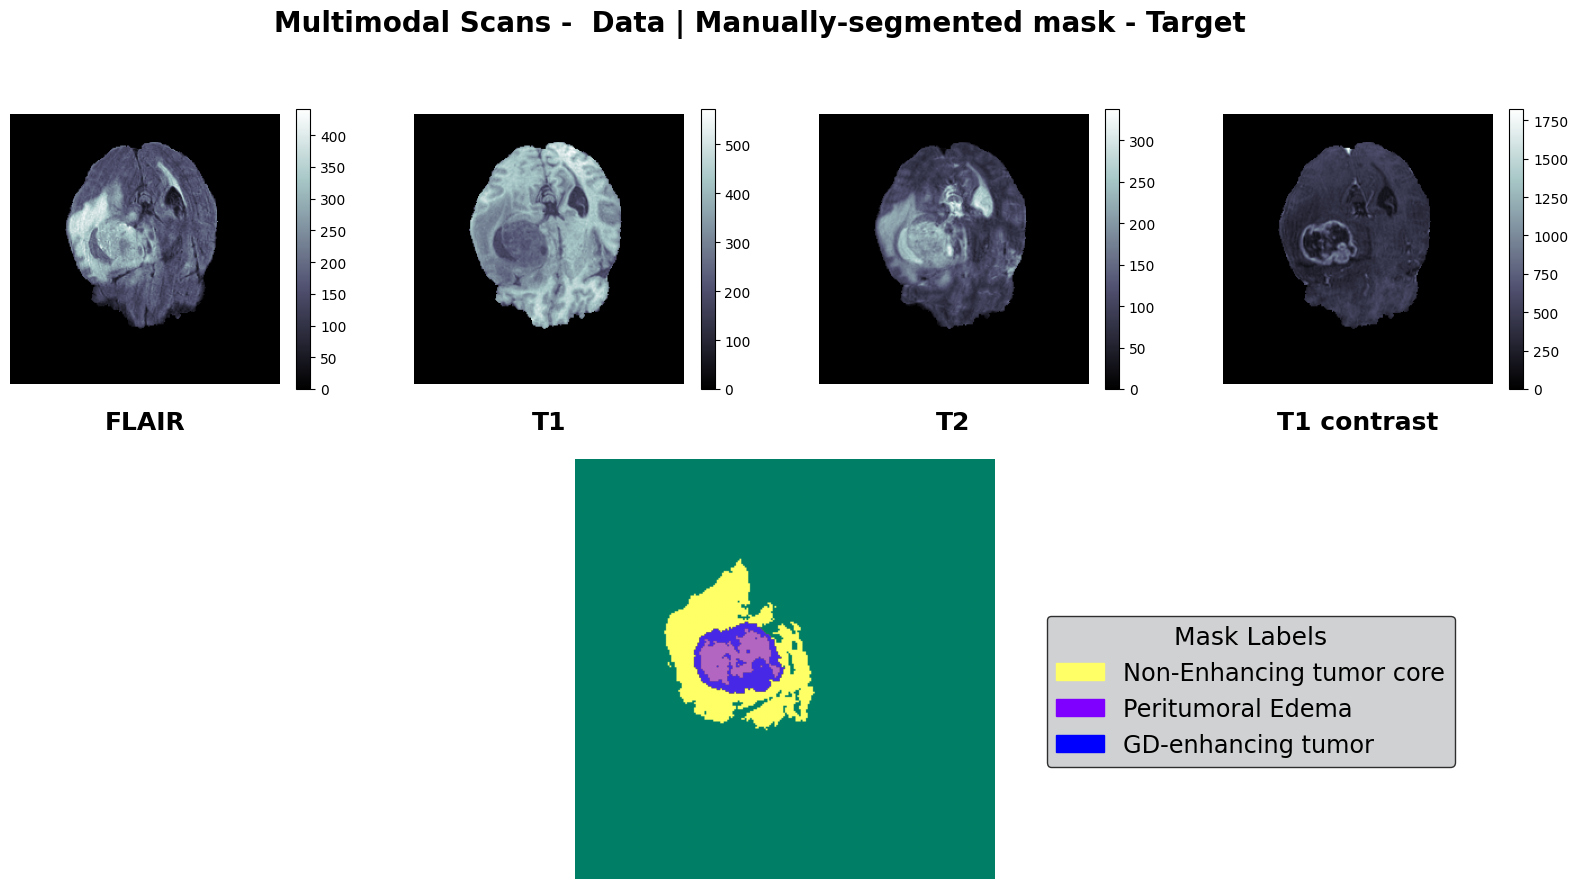

In [ ]:
# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self,
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z

    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)


    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean

    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)

        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)

        return resized_data

    def plot_cube(self,
                  cube,
                  title: str = '',
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")

        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()


class ShowResult:

    def mask_preprocessing(self, mask):
        """
        Test.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img

    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)

        fig, axes = plt.subplots(1, 2, figsize = (35, 30))

        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()

        plt.show()

#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])


def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merging GIFs side by side.
    Parameters:
        path1: path to gif with ground truth.
        path2: path to gif with prediction.
        name_to_save: name for saving new GIF.
    """
    #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length())

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()
    new_gif.close()

#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif',
#                'result.gif')

def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path)
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

#csv_paths = get_all_csv_file("../input/brats20-dataset-training-validation/BraTS2020_TrainingData")

In [ ]:
class GlobalConfig:
    root_dir = '/content/brats20-dataset-training-validation'
    train_root_dir = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'
    pretrained_model_path = '/content/bc16.pth'
    train_logs_path = '/content/train_log_emp.csv'
    #ae_pretrained_model_path = '../input/brats20logs/brats2020logs/ae/autoencoder_best_model.pth'
    #tab_data = '../input/brats20logs/brats2020logs/data/df_with_voxel_stats_and_latent_features.csv'
    seed = 55

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

In [ ]:
survival_info_df = pd.read_csv('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for _, row  in df.iterrows():

    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]

    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)

df['path'] = paths

#split data on train, test, split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
#train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)


In [ ]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)

            if self.is_resize:
                img = self.resize(img)

            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))

        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)

            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)

            augmented = self.augmentations(image=img.astype(np.float32),
                                           mask=mask.astype(np.float32))

            img = augmented['image']
            mask = augmented['mask']


            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }

        return {
            "Id": id_,
            "image": img,
        }

    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)

    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data

    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

In [ ]:
def get_augmentations(phase):
    list_transforms = []

    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)

    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [ ]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [ ]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_162'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

In [ ]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.reshape(num, -1)
        targets = targets.reshape(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score


class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss

# helper functions for testing.
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [ ]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [ ]:
class KAN3D(nn.Module):
    """
    3D KAN wrapper supporting flat, block-wise, and channel-wise modes with residual injection.
    """
    def __init__(
        self,
        num_channels,
        mode: str = "flat",              # "flat", "block", or "channel"
        block_size: tuple = (32, 32, 32),  # only used for block mode
        **kan_kwargs
    ):
        super().__init__()
        assert mode in {"flat", "block", "channel"}, "mode must be 'flat', 'block', or 'channel'"
        self.mode = mode
        self.block_size = block_size
        self.in_ch = num_channels
        # two-layer KAN mapping C -> C
        self.kan = KAN([num_channels, num_channels], **kan_kwargs)

    def forward(self, x):
        N, C, D, H, W = x.shape
        assert C == self.in_ch, f"Expected {self.in_ch} channels, got {C}"

        # FLAT mode: flatten all voxels, apply KAN, then residual
        if self.mode == "flat":
            flat = x.permute(0,2,3,4,1).reshape(-1, C)
            y = self.kan(flat) + flat
            y = y.reshape(N, D, H, W, C).permute(0,4,1,2,3)
            return y

        # CHANNEL mode: treat as 1x1x1 conv
        if self.mode == "channel":
            flat = x.permute(0,2,3,4,1).reshape(-1, C)
            # split into chunks to limit memory
            chunks = flat.split(1_000_000, dim=0)
            out_chunks = []
            for chunk in chunks:
                out_chunks.append(self.kan(chunk) + chunk)
            y = torch.cat(out_chunks, dim=0)
            y = y.reshape(N, D, H, W, C).permute(0,4,1,2,3)
            return y

        # BLOCK mode: split volume into subcubes of block_size
        bD, bH, bW = self.block_size
        padD = (bD - D % bD) % bD
        padH = (bH - H % bH) % bH
        padW = (bW - W % bW) % bW
        x_pad = F.pad(x, (0,padW, 0,padH, 0,padD))
        ND, NH, NW = D+padD, H+padH, W+padW
        # reshape into blocks
        x_blocks = x_pad.view(
            N, C,
            ND//bD, bD,
            NH//bH, bH,
            NW//bW, bW
        ).permute(0,2,4,6,1,3,5,7)
        # (N, nD, nH, nW, C, bD, bH, bW)
        nD, nH, nW = ND//bD, NH//bH, NW//bW
        x_blocks = x_blocks.reshape(-1, C, bD, bH, bW)

        # apply KAN inside each block
        out_blocks = []
        # process small batches of blocks
        for blk in x_blocks.split(16, dim=0):
            nb = blk.shape[0]
            flat = blk.permute(0,2,3,4,1).reshape(-1, C)
            yblk = self.kan(flat) + flat
            yblk = yblk.reshape(nb, bD, bH, bW, C).permute(0,4,1,2,3)
            out_blocks.append(yblk)
        out = torch.cat(out_blocks, dim=0)

        # reassemble blocks
        out = out.view(
            N, nD, nH, nW,
            C, bD, bH, bW
        ).permute(0,4,1,5,2,6,3,7)
        out = out.reshape(N, C, ND, NH, NW)
        # crop padding
        return out[:, :, :D, :H, :W]


# U-Net components
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, num_groups=4):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x): return self.encoder(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, trilinear=True):
        super().__init__()
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_ch//2, in_ch//2, 2, 2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x2.size(2) - x1.size(2)
        diffY = x2.size(3) - x1.size(3)
        diffX = x2.size(4) - x1.size(4)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2,
                        diffZ//2, diffZ-diffZ//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Out(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, 1)
    def forward(self, x): return self.conv(x)

In [ ]:
class UNet3dKAN(nn.Module):
    def __init__(self, in_channels, n_classes, base_channels=32,
                 kan_mode='flat', block_size=(32,32,32), kan_kwargs=None):
        super().__init__()
        kan_kwargs = kan_kwargs or {}

        # Encoder
        self.enc0 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, 2*base_channels)
        self.down2 = Down(2*base_channels, 4*base_channels)
        self.down3 = Down(4*base_channels, 8*base_channels)
        self.kan_enc = KAN3D(8*base_channels, mode=kan_mode, block_size=block_size, **kan_kwargs)

        # Bottleneck conv + KAN
        self.bottleneck = DoubleConv(8*base_channels, 8*base_channels)
        self.kan_bottleneck = KAN3D(8*base_channels, mode=kan_mode, block_size=block_size, **kan_kwargs)

        # Decoder
        self.up1 = Up(12*base_channels, 4*base_channels)
        self.kan_dec = KAN3D(4*base_channels, mode=kan_mode, block_size=block_size, **kan_kwargs)
        self.up2 = Up(6*base_channels, 2*base_channels)
        self.up3 = Up(3*base_channels, base_channels)

        # Output
        self.outc = Out(base_channels, n_classes)

    def forward(self, x):
        x0 = self.enc0(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x3 = self.kan_enc(x3)

        # bottleneck
        x_b = self.bottleneck(x3)
        x_b = self.kan_bottleneck(x_b)

        # decoder
        x = self.up1(x_b, x2)
        x = self.kan_dec(x)
        x = self.up2(x, x1)
        x = self.up3(x, x0)

        return self.outc(x)

# Example instantiation
torch.manual_seed(0)
kan_params = dict(
    grid_size=5, spline_order=3, scale_noise=0.1,
    scale_base=1.0, scale_spline=1.0,
    base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1,1]
)
model = UNet3dKAN(in_channels=4, n_classes=3, base_channels=16,
                  kan_mode='block', block_size=(32,32,32), kan_kwargs=kan_params).cuda()
x = torch.randn(1,4,155,240,240).cuda()
out = model(x)
print("Output shape:", out.shape)  # -> [1,3,155,240,240]

Output shape: torch.Size([1, 3, 155, 240, 240])


In [ ]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        # Use tqdm to show progress during batch iteration
        with tqdm(enumerate(dataloader), total=total_batches, desc=f"{phase} Epoch {epoch}") as pbar:
            for itr, data_batch in pbar:
                images, targets = data_batch['image'], data_batch['mask']
                loss, logits = self._compute_loss_and_outputs(images, targets)
                loss = loss / self.accumulation_steps
                if phase == "train":
                    loss.backward()
                    if (itr + 1) % self.accumulation_steps == 0:
                        self.optimizer.step()
                        self.optimizer.zero_grad()
                running_loss += loss.item()
                meter.update(logits.detach().cpu(), targets.detach().cpu())

                # Update progress bar with loss information
                pbar.set_postfix(loss=running_loss / (itr + 1))

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]}
            """,

            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-v0_8-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [ ]:
trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=50,
                  path_to_csv = config.path_to_csv,)

if config.pretrained_model_path is not None:
    #trainer.load_predtrain_model(config.pretrained_model_path)

    # if need - load the logs.
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda


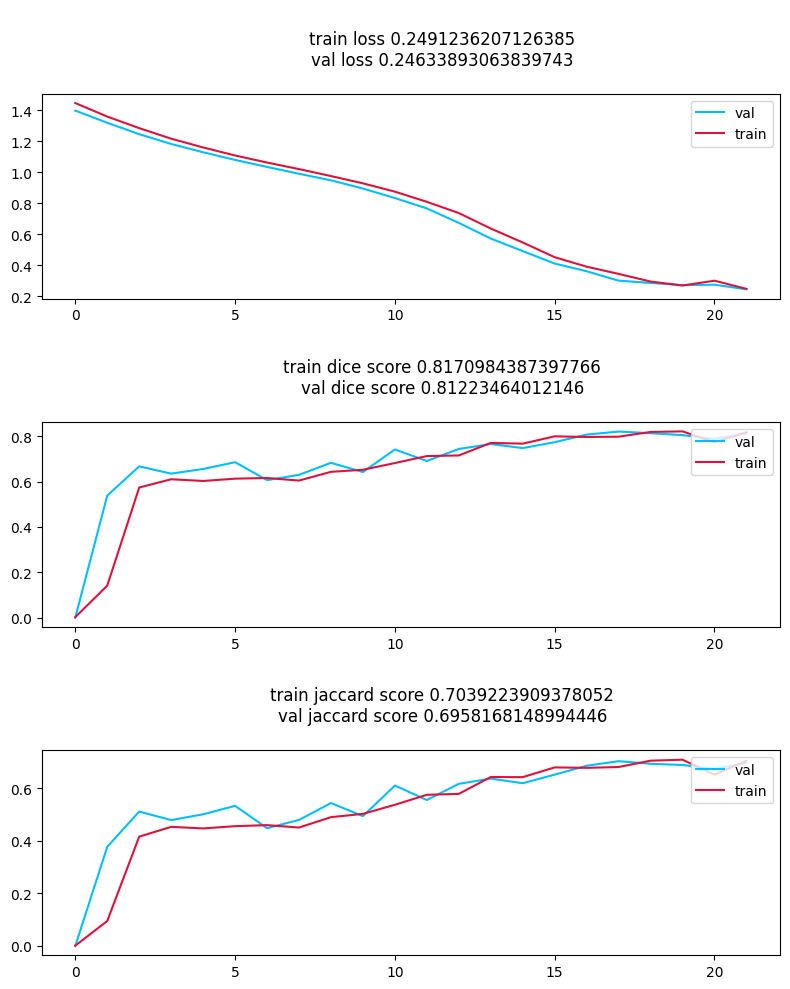


####################
Saved new checkpoint
####################


train epoch 22 | time: 04:53:46


train Epoch 22:  60%|█████▉    | 120/201 [02:28<01:40,  1.24s/it, loss=0.062]


KeyboardInterrupt: 

In [ ]:
%%time
trainer.run()

In [ ]:
# def compute_scores_per_classes(model,
#                                dataloader,
#                                classes):
#     """
#     Compute Dice and Jaccard coefficients for each class.
#     Params:
#         model: neural net for make predictions.
#         dataloader: dataset object to load data from.
#         classes: list with classes.
#         Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
#     """
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     dice_scores_per_classes = {key: list() for key in classes}
#     iou_scores_per_classes = {key: list() for key in classes}

#     with torch.no_grad():
#         for i, data in enumerate(dataloader):
#             imgs, targets = data['image'], data['mask']
#             imgs, targets = imgs.to(device), targets.to(device)
#             logits = model(imgs)
#             logits = logits.detach().cpu().numpy()
#             targets = targets.detach().cpu().numpy()

#             dice_scores = dice_coef_metric_per_classes(logits, targets)
#             iou_scores = jaccard_coef_metric_per_classes(logits, targets)

#             for key in dice_scores.keys():
#                 dice_scores_per_classes[key].extend(dice_scores[key])

#             for key in iou_scores.keys():
#                 iou_scores_per_classes[key].extend(iou_scores[key])

#     return dice_scores_per_classes, iou_scores_per_classes

In [ ]:
model.eval();

In [ ]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [ ]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance_metric_per_classes(probabilities: np.ndarray,
                                          truth: np.ndarray,
                                          threshold: float = 0.5,
                                          eps: float = 1e-9,
                                          classes: list = ['WT', 'TC', 'ET'],
                                          percentile: float = 95) -> np.ndarray:
    """
    Calculate Hausdorff distance (95th percentile) for data batch and for each class.
    Params:
        probabilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with class names.
        percentile: percentile to calculate Hausdorff distance (default is 95th).
        Returns: dict with Hausdorff distances for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= threshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]

            # Get the coordinates of the non-zero pixels (boundary points)
            pred_coords = np.argwhere(prediction > 0)
            truth_coords = np.argwhere(truth_ > 0)

            if len(pred_coords) == 0 or len(truth_coords) == 0:
                # If there are no positive points in either the prediction or the truth
                scores[classes[class_]].append(np.inf)
                continue

            # Compute the directed Hausdorff distance between prediction and truth
            hausdorff_dist_pred_to_truth = directed_hausdorff(pred_coords, truth_coords)[0]
            hausdorff_dist_truth_to_pred = directed_hausdorff(truth_coords, pred_coords)[0]
            hausdorff_dist = max(hausdorff_dist_pred_to_truth, hausdorff_dist_truth_to_pred)

            scores[classes[class_]].append(hausdorff_dist)

    # Calculate the desired percentile (e.g., 95th percentile) for each class
    percentile_scores = {class_: np.percentile(scores[class_], percentile) for class_ in classes}

    return percentile_scores

def compute_scores_per_classes(model,
                               dataloader,
                               classes,
                               percentile: float = 95,
                               convert_to_mm: bool = True):
    """
    Compute Dice, Jaccard, and Hausdorff distances (95th percentile) for each class.
    Optionally converts Hausdorff distance to millimeters.

    Params:
        model: neural net for making predictions.
        dataloader: dataset object to load data from.
        classes: list with class names.
        percentile: percentile to calculate Hausdorff distance (default is 95th).
        convert_to_mm: whether to convert Hausdorff distance to mm (default is True).

    Returns:
        Dictionaries with Dice, Jaccard coefficients, and Hausdorff distances for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    hausdorff_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            # Calculate Dice, Jaccard, and Hausdorff distances
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            hausdorff_scores = hausdorff_distance_metric_per_classes(logits, targets, percentile=percentile)

            # Store the results for each class
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

            for key in hausdorff_scores.keys():
                if convert_to_mm:
                    # If Hausdorff distance is not in mm, multiply by a conversion factor
                    # This factor would depend on the data and model, e.g., it could be a scaling factor
                    # For example, let's assume the values are in pixels and need to be converted to mm.
                    conversion_factor = 0.01  # Replace with actual conversion factor if needed (e.g., 1.0 if already in mm)
                    hausdorff_scores_per_classes[key].append(hausdorff_scores[key] * conversion_factor)
                else:
                    hausdorff_scores_per_classes[key].append(hausdorff_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes, hausdorff_scores_per_classes

# Usage Example:
# Assuming `nodel` is your model and `val_dataloader` is the validation dataloader
dice_scores_per_classes, iou_scores_per_classes, hausdorff_scores_per_classes = compute_scores_per_classes(
    model, val_dataloader, ['WT', 'TC', 'ET'], percentile=95, convert_to_mm=True
)


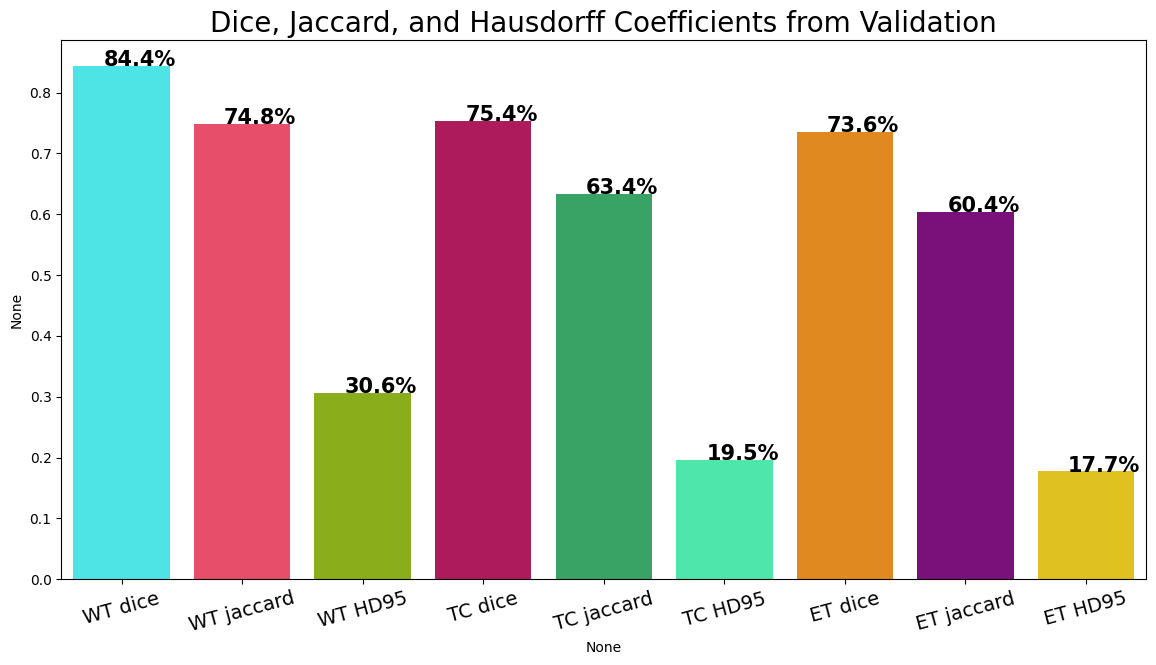

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `dice_scores_per_classes`, `iou_scores_per_classes`, and `hausdorff_scores_per_classes` are already defined
# Create DataFrames from the Dice, IoU, and Hausdorff scores
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']

hausdorff_df = pd.DataFrame(hausdorff_scores_per_classes)
hausdorff_df.columns = ['WT HD95', 'TC HD95', 'ET HD95']

# Combine all the DataFrames into one
val_metrics_df = pd.concat([dice_df, iou_df, hausdorff_df], axis=1, sort=True)

# Reorder columns to match desired order
val_metrics_df = val_metrics_df.loc[:, ['WT dice', 'WT jaccard', 'WT HD95',
                                         'TC dice', 'TC jaccard', 'TC HD95',
                                         'ET dice', 'ET jaccard', 'ET HD95']]

# Set custom color palette
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#FF8C00', '#8B008B', '#FFD700']
palette = sns.color_palette(colors, 9)

# Plot the mean values for each class
fig, ax = plt.subplots(figsize=(14, 7))

# Plot bar chart
sns.barplot(x=val_metrics_df.mean().index, y=val_metrics_df.mean(), palette=palette, ax=ax)

# Customize x-axis labels
ax.set_xticklabels(val_metrics_df.columns, fontsize=14, rotation=15)
ax.set_title("Dice, Jaccard, and Hausdorff Coefficients from Validation", fontsize=20)

# Annotate each bar with the percentage value
for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metrics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

# Save the figure in both PNG and SVG formats
fig.savefig("result_with_hd95.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result_with_hd95.svg", format="svg", pad_inches=0.2, transparent=False, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)

            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()

            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)

            # only 5 pars
            if (i > 5):
                return results
        return results

In [ ]:
%%time
results = compute_results(
    model, val_dataloader, 0.33)

CPU times: user 3.53 s, sys: 2.24 s, total: 5.77 s
Wall time: 5.53 s


In [ ]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):

    print(id_)
    break

['BraTS20_Training_008']


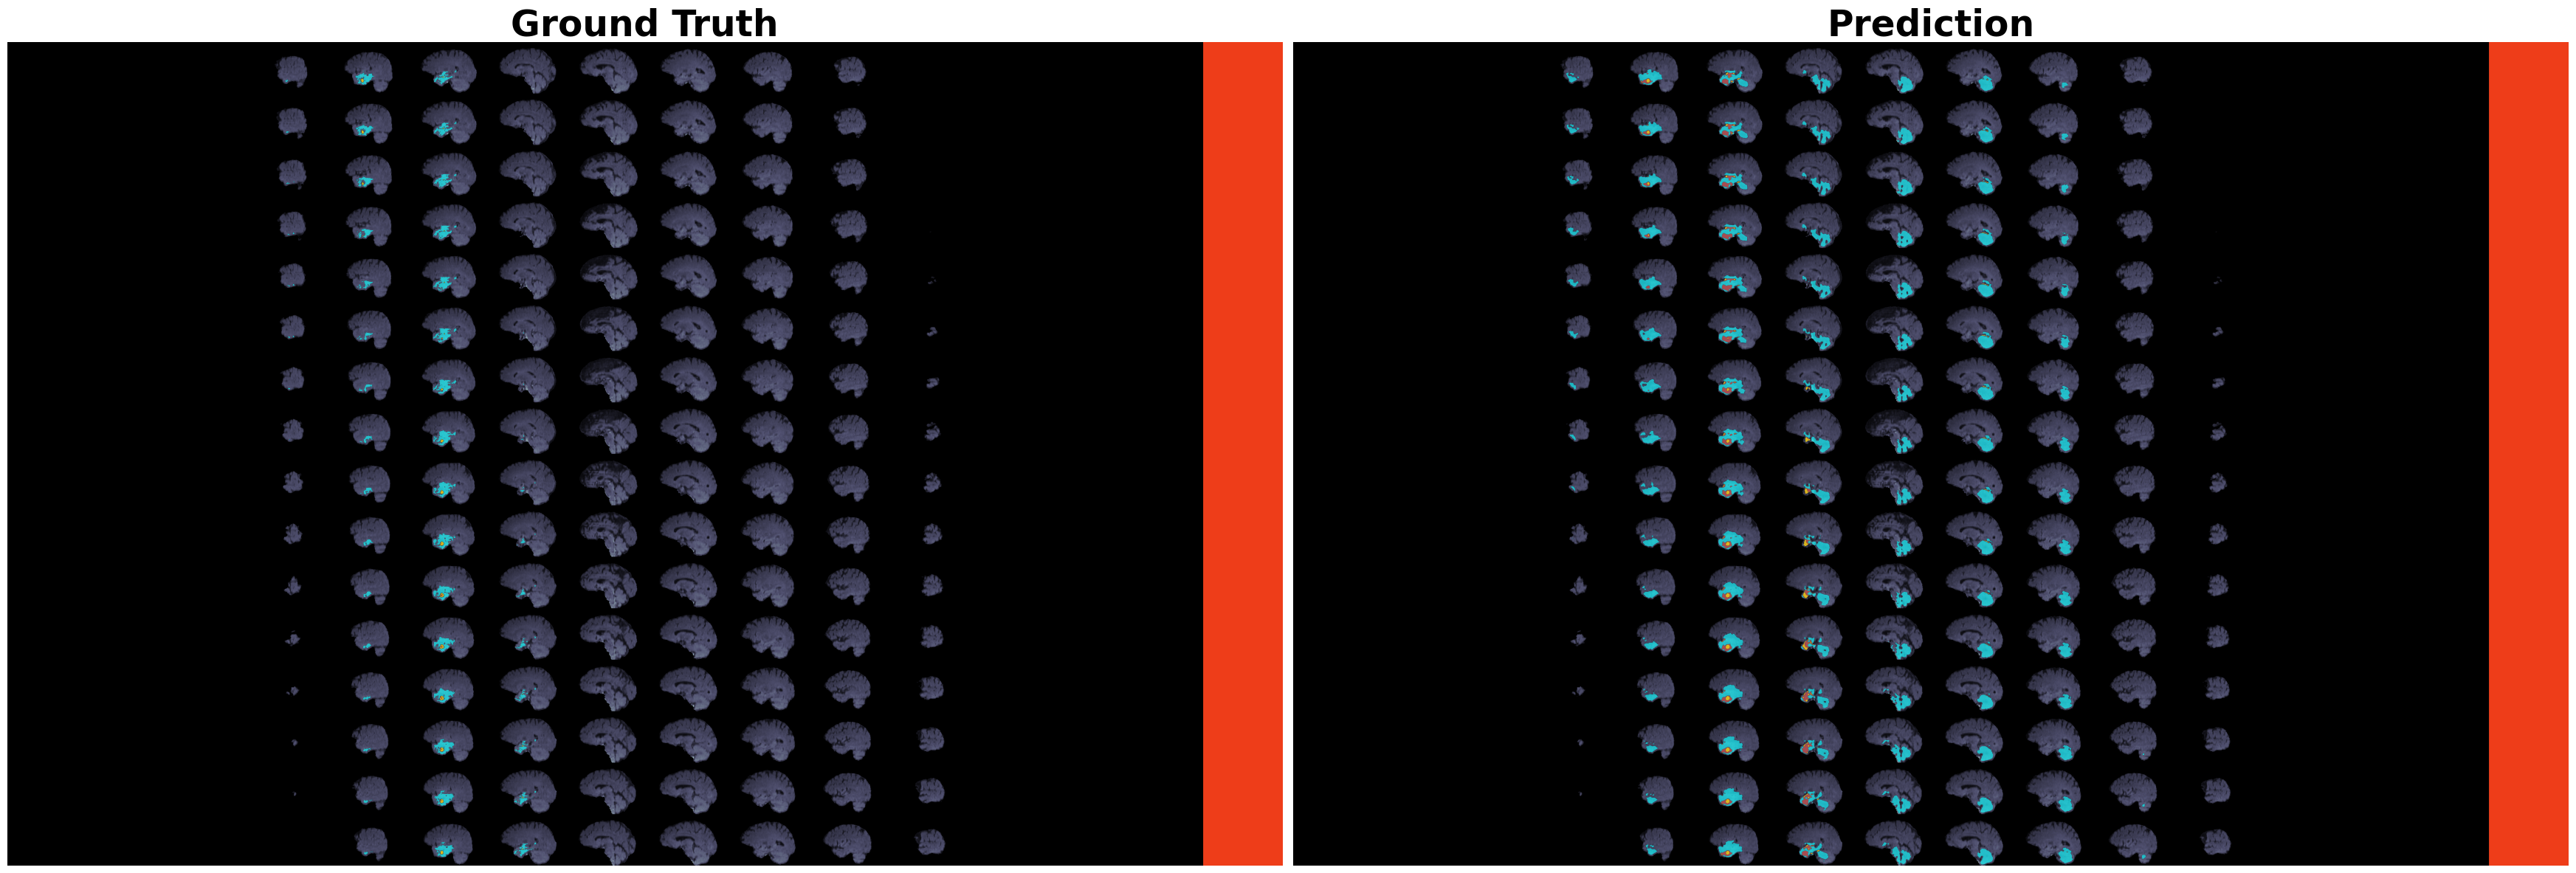

In [ ]:
show_result = ShowResult()
show_result.plot(img, gt, prediction)

In [ ]:
gt = gt.squeeze().cpu().detach().numpy()
gt = np.moveaxis(gt, (0, 1, 2, 3), (0, 3, 2, 1))
wt,tc, et = gt
print(wt.shape, tc.shape, et.shape)
gt = (wt + tc + et)
gt = np.clip(gt, 0, 1)
print(gt.shape)

(240, 240, 155) (240, 240, 155) (240, 240, 155)
(240, 240, 155)


In [ ]:
prediction = prediction.squeeze().cpu().detach().numpy()
prediction = np.moveaxis(prediction, (0, 1, 2, 3), (0, 3, 2, 1))
wt,tc,et = prediction
print(wt.shape, tc.shape, et.shape)
prediction = (wt + tc + et)
prediction = np.clip(prediction, 0, 1)
print(prediction.shape)

(240, 240, 155) (240, 240, 155) (240, 240, 155)
(240, 240, 155)
